# **Aircraft Predictive Maintenance**

# Introduction
a

In [1]:
# Importing libraries

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Data Sources
a

In [2]:
# Defining dataset to use

FD = 'FD004'

In [3]:
# Defining column names

id_cols = ['unit', 'cycle'] # Identifiers
op_cols = ['op_setting_1', 'op_setting_2', 'op_setting_3'] # Operating conditions
sensor_cols = [f'sensor_{i}' for i in range(1, 22)] # Sensors 1-21

cols = id_cols + op_cols + sensor_cols

In [4]:
# Defining data file paths

base = '../data/raw/cmapss'

train_path = f'{base}/train_{FD}.txt'
test_path = f'{base}/test_{FD}.txt'
rul_path = f'{base}/rul_{FD}.txt'

## Train Data
a

In [5]:
# Loading the train data

df_train = pd.read_csv(train_path, sep=r'\s+', header=None)

df_train = df_train.iloc[:, :len(cols)]
df_train.columns = cols

df_train

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,249,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,...,380.16,2388.73,8185.69,8.4541,0.03,372,2319,100.00,29.11,17.5234
61245,249,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,...,535.02,2388.46,8185.47,8.2221,0.03,396,2388,100.00,39.38,23.7151
61246,249,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,...,535.41,2388.48,8193.94,8.2525,0.03,395,2388,100.00,39.78,23.8270
61247,249,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,...,187.92,2388.83,8125.64,9.0515,0.02,337,2223,100.00,15.26,9.0774


In [6]:
# Checking df_train data types

df_train.dtypes

unit              int64
cycle             int64
op_setting_1    float64
op_setting_2    float64
op_setting_3    float64
sensor_1        float64
sensor_2        float64
sensor_3        float64
sensor_4        float64
sensor_5        float64
sensor_6        float64
sensor_7        float64
sensor_8        float64
sensor_9        float64
sensor_10       float64
sensor_11       float64
sensor_12       float64
sensor_13       float64
sensor_14       float64
sensor_15       float64
sensor_16       float64
sensor_17         int64
sensor_18         int64
sensor_19       float64
sensor_20       float64
sensor_21       float64
dtype: object

## Test Data
a

In [7]:
# Loading the test data

df_test = pd.read_csv(test_path, sep=r'\s+', header=None)

df_test = df_test.iloc[:, :len(cols)]
df_test.columns = cols

df_test

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,313.03,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,163.61,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,129.98,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,129.48,2387.90,8078.89,9.3594,0.02,328,2212,100.00,10.56,6.2367
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,181.82,2387.87,8057.83,9.3030,0.02,333,2223,100.00,14.85,8.9326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41209,248,277,41.9991,0.8401,100.0,445.00,550.30,1364.40,1129.17,3.91,...,130.87,2388.50,8112.61,9.4427,0.02,331,2212,100.00,10.53,6.2620
41210,248,278,20.0026,0.7005,100.0,491.19,608.00,1494.75,1260.88,9.35,...,314.51,2388.33,8086.83,9.2772,0.02,366,2324,100.00,24.33,14.6486
41211,248,279,34.9988,0.8413,100.0,449.44,555.92,1370.65,1130.97,5.48,...,182.76,2388.64,8100.84,9.3982,0.02,336,2223,100.00,14.69,8.8389
41212,248,280,20.0027,0.7000,100.0,491.19,608.19,1489.11,1256.25,9.35,...,314.17,2388.37,8085.24,9.2727,0.03,366,2324,100.00,24.44,14.6887


In [8]:
# Checking df_test data types

df_test.dtypes

unit              int64
cycle             int64
op_setting_1    float64
op_setting_2    float64
op_setting_3    float64
sensor_1        float64
sensor_2        float64
sensor_3        float64
sensor_4        float64
sensor_5        float64
sensor_6        float64
sensor_7        float64
sensor_8        float64
sensor_9        float64
sensor_10       float64
sensor_11       float64
sensor_12       float64
sensor_13       float64
sensor_14       float64
sensor_15       float64
sensor_16       float64
sensor_17         int64
sensor_18         int64
sensor_19       float64
sensor_20       float64
sensor_21       float64
dtype: object

## RUL Data
a

In [9]:
# Loading the RUL data

df_rul = pd.read_csv(rul_path, header=None, names=['RUL'])

df_rul

,RUL
0,22
1,39
2,107
3,75
4,149
...,...
243,35
244,131
245,194
246,112


In [10]:
# Checking df_rul data types

df_rul.dtypes

RUL    int64
dtype: object

# Data Preprocessing
a

## Standardising Data Types
a

In [11]:
# Defining float and integer columns

int_cols = ['unit', 'cycle']
float_cols = [c for c in df_train.columns if c not in ['unit', 'cycle']]

In [12]:
# Converting identifier columns into integers and everything else into floats

df_train[int_cols] = df_train[int_cols].astype(int)
df_test[int_cols] = df_test[int_cols].astype(int)

df_train[float_cols] = df_train[float_cols].astype(float)
df_test[float_cols] = df_test[float_cols].astype(float)

In [13]:
# Confirming df_train data types

df_train.dtypes

unit              int32
cycle             int32
op_setting_1    float64
op_setting_2    float64
op_setting_3    float64
sensor_1        float64
sensor_2        float64
sensor_3        float64
sensor_4        float64
sensor_5        float64
sensor_6        float64
sensor_7        float64
sensor_8        float64
sensor_9        float64
sensor_10       float64
sensor_11       float64
sensor_12       float64
sensor_13       float64
sensor_14       float64
sensor_15       float64
sensor_16       float64
sensor_17       float64
sensor_18       float64
sensor_19       float64
sensor_20       float64
sensor_21       float64
dtype: object

In [14]:
# Confirming df_test data types

df_test.dtypes

unit              int32
cycle             int32
op_setting_1    float64
op_setting_2    float64
op_setting_3    float64
sensor_1        float64
sensor_2        float64
sensor_3        float64
sensor_4        float64
sensor_5        float64
sensor_6        float64
sensor_7        float64
sensor_8        float64
sensor_9        float64
sensor_10       float64
sensor_11       float64
sensor_12       float64
sensor_13       float64
sensor_14       float64
sensor_15       float64
sensor_16       float64
sensor_17       float64
sensor_18       float64
sensor_19       float64
sensor_20       float64
sensor_21       float64
dtype: object

## Sorting by Engine and Time
a

In [15]:
# Sorting df_train by engine and time

df_train = df_train.sort_values(['unit', 'cycle']).reset_index(drop=True)

df_train

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,129.78,2387.99,8074.83,9.3335,0.02,330.0,2212.0,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,312.59,2387.73,8046.13,9.1913,0.02,361.0,2324.0,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,129.62,2387.97,8066.62,9.4007,0.02,329.0,2212.0,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,129.80,2388.02,8076.05,9.3369,0.02,328.0,2212.0,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,164.11,2028.08,7865.80,10.8366,0.02,305.0,1915.0,84.93,14.03,8.6754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,249,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,...,380.16,2388.73,8185.69,8.4541,0.03,372.0,2319.0,100.00,29.11,17.5234
61245,249,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,...,535.02,2388.46,8185.47,8.2221,0.03,396.0,2388.0,100.00,39.38,23.7151
61246,249,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,...,535.41,2388.48,8193.94,8.2525,0.03,395.0,2388.0,100.00,39.78,23.8270
61247,249,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,...,187.92,2388.83,8125.64,9.0515,0.02,337.0,2223.0,100.00,15.26,9.0774


In [16]:
# Sorting df_test by engine and time

df_test = df_test.sort_values(['unit', 'cycle']).reset_index(drop=True)

df_test

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,313.03,2387.78,8048.98,9.2229,0.02,362.0,2324.0,100.00,24.31,14.7007
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,163.61,2028.09,7863.46,10.8632,0.02,306.0,1915.0,84.93,14.36,8.5748
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,129.98,2387.95,8071.13,9.3960,0.02,328.0,2212.0,100.00,10.39,6.4365
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,129.48,2387.90,8078.89,9.3594,0.02,328.0,2212.0,100.00,10.56,6.2367
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,181.82,2387.87,8057.83,9.3030,0.02,333.0,2223.0,100.00,14.85,8.9326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41209,248,277,41.9991,0.8401,100.0,445.00,550.30,1364.40,1129.17,3.91,...,130.87,2388.50,8112.61,9.4427,0.02,331.0,2212.0,100.00,10.53,6.2620
41210,248,278,20.0026,0.7005,100.0,491.19,608.00,1494.75,1260.88,9.35,...,314.51,2388.33,8086.83,9.2772,0.02,366.0,2324.0,100.00,24.33,14.6486
41211,248,279,34.9988,0.8413,100.0,449.44,555.92,1370.65,1130.97,5.48,...,182.76,2388.64,8100.84,9.3982,0.02,336.0,2223.0,100.00,14.69,8.8389
41212,248,280,20.0027,0.7000,100.0,491.19,608.19,1489.11,1256.25,9.35,...,314.17,2388.37,8085.24,9.2727,0.03,366.0,2324.0,100.00,24.44,14.6887


## Duplicate Row Check
a

In [17]:
# Checking for duplicate rows

print(f'df_train Duplicates: {df_train.duplicated(subset=['unit', 'cycle']).sum()}')
print(f'df_test Duplicates: {df_test.duplicated(subset=['unit', 'cycle']).sum()}')

df_train Duplicates: 0
df_test Duplicates: 0


## Missing Value Check
a

In [18]:
# Checking for missing values in df_train

df_train.isna().sum().sort_values(ascending=False).head()

unit         0
cycle        0
sensor_20    0
sensor_19    0
sensor_18    0
dtype: int64

In [19]:
# Checking for missing values in df_test

df_test.isna().sum().sort_values(ascending=False).head()

unit         0
cycle        0
sensor_20    0
sensor_19    0
sensor_18    0
dtype: int64

## Creating the Remaining Useful Life (RUL) Target
a

### RUL for the Train Data
a
$$
RUL = \max(\text{cycle}_{\text{unit}}) - \text{cycle}
$$

In [20]:
# Creating the RUL target for the train data

max_cycle_train = df_train.groupby('unit')['cycle'].max()
df_train['RUL'] = df_train['unit'].map(max_cycle_train) - df_train['cycle']

df_train

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330.0,2212.0,100.00,10.62,6.3670,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361.0,2324.0,100.00,24.37,14.6552,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329.0,2212.0,100.00,10.48,6.4213,318
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328.0,2212.0,100.00,10.54,6.4176,317
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305.0,1915.0,84.93,14.03,8.6754,316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,249,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,...,2388.73,8185.69,8.4541,0.03,372.0,2319.0,100.00,29.11,17.5234,4
61245,249,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,...,2388.46,8185.47,8.2221,0.03,396.0,2388.0,100.00,39.38,23.7151,3
61246,249,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,...,2388.48,8193.94,8.2525,0.03,395.0,2388.0,100.00,39.78,23.8270,2
61247,249,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,...,2388.83,8125.64,9.0515,0.02,337.0,2223.0,100.00,15.26,9.0774,1


### RUL for the Test Data
a
$$
RUL = RUL_{\text{end}} + \left(\max(\text{cycle}_{\text{test, unit}}) - \text{cycle}\right)
$$

In [21]:
# Adding a column for units to df_rul

df_rul['unit'] = df_rul.index + 1

df_rul

,RUL,unit
0,22,1
1,39,2
2,107,3
3,75,4
4,149,5
...,...,...
243,35,244
244,131,245
245,194,246
246,112,247


In [22]:
# Calculating the maximum observed cycle for the test data

max_cycle_test = df_test.groupby('unit')['cycle'].max()

In [23]:
# Merging and creating the RUL target for the test data

df_test = df_test.merge(max_cycle_test.rename('max_cycle'), on='unit', how='left')
df_test = df_test.merge(df_rul, on='unit', how='left')

df_test['RUL'] = df_test['RUL'] + (df_test['max_cycle'] - df_test['cycle'])

df_test.drop(columns=['max_cycle'], inplace=True)

df_test

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,2387.78,8048.98,9.2229,0.02,362.0,2324.0,100.00,24.31,14.7007,251
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,2028.09,7863.46,10.8632,0.02,306.0,1915.0,84.93,14.36,8.5748,250
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,2387.95,8071.13,9.3960,0.02,328.0,2212.0,100.00,10.39,6.4365,249
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,2387.90,8078.89,9.3594,0.02,328.0,2212.0,100.00,10.56,6.2367,248
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,2387.87,8057.83,9.3030,0.02,333.0,2223.0,100.00,14.85,8.9326,247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41209,248,277,41.9991,0.8401,100.0,445.00,550.30,1364.40,1129.17,3.91,...,2388.50,8112.61,9.4427,0.02,331.0,2212.0,100.00,10.53,6.2620,30
41210,248,278,20.0026,0.7005,100.0,491.19,608.00,1494.75,1260.88,9.35,...,2388.33,8086.83,9.2772,0.02,366.0,2324.0,100.00,24.33,14.6486,29
41211,248,279,34.9988,0.8413,100.0,449.44,555.92,1370.65,1130.97,5.48,...,2388.64,8100.84,9.3982,0.02,336.0,2223.0,100.00,14.69,8.8389,28
41212,248,280,20.0027,0.7000,100.0,491.19,608.19,1489.11,1256.25,9.35,...,2388.37,8085.24,9.2727,0.03,366.0,2324.0,100.00,24.44,14.6887,27


### Train Data Minimum RUL Check
a

In [24]:
# Checking descriptive statistics of the RUL for the train data

df_train['RUL'].describe()

count    61249.000000
mean       133.311417
std         89.783389
min          0.000000
25%         61.000000
50%        122.000000
75%        190.000000
max        542.000000
Name: RUL, dtype: float64

[min being 0]

### Test Data Minimum RUL Check
a

In [25]:
# Checking the minimum value of the RUL for the test data

df_test.groupby('unit')['RUL'].min()

unit
1       22
2       39
3      107
4       75
5      149
      ... 
244     35
245    131
246    194
247    112
248     26
Name: RUL, Length: 248, dtype: int64

[RUL not being 0]

### Checking the Last Timestep per Unit
a

In [26]:
# Checking the last timestep per unit

df_test.loc[df_test.groupby('unit')['cycle'].idxmax(), ['unit', 'cycle', 'RUL']]

,unit,cycle,RUL
229,1,230,22
382,2,153,39
523,3,141,107
731,4,208,75
782,5,51,149
...,...,...,...
40746,244,184,35
40809,245,63,131
40838,246,29,194
40932,247,94,112


[RUL matching values in df_rul]

### RUL Degradation Visualisation
a

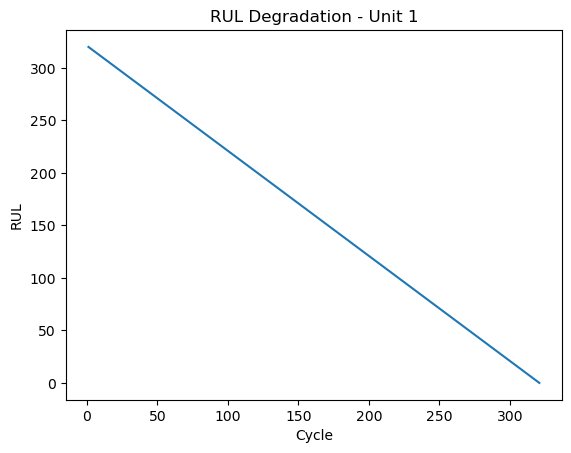

In [27]:
# Visualising RUL degradation

unit_example = 1

subset = df_train[df_train['unit'] == unit_example]

plt.plot(subset['cycle'], subset['RUL'])
plt.xlabel('Cycle')
plt.ylabel('RUL')
plt.title(f'RUL Degradation - Unit {unit_example}')
plt.show()

[straight line going to 0]

## RUL Capping
a

In [28]:
# Capping the RUL

RUL_CAP = 125

df_train['RUL_capped'] = df_train['RUL'].clip(upper=RUL_CAP)
df_test['RUL_capped'] = df_test['RUL'].clip(upper=RUL_CAP)

print(df_train['RUL'].max(), df_train['RUL_capped'].max())
print(df_test['RUL'].max(), df_test['RUL_capped'].max())

542 125
553 125


## Checking for Near-Constant Features
a

In [29]:
# Defining feature columns

feature_cols = [c for c in df_train.columns if c.startswith('op_setting_') or c.startswith('sensor_')]

In [30]:
# Identifying low-variance columns on df_train

variances = df_train[feature_cols].var()
low_var_cols = variances[variances < 1e-8].index.tolist()

print(f'Low-Variance Columns: {low_var_cols}')
print(f'Count: {len(low_var_cols)}')

Low-Variance Columns: []
Count: 0


In [31]:
# Dropping low-variance columns from df_train, df_test and feature_cols

df_train = df_train.drop(columns=low_var_cols)
df_test = df_test.drop(columns=low_var_cols)

In [32]:
# Saving the list of low-variance columns for reproducibility

with open(f'../data/processed/dropped_low_variance_columns_{FD}.json', 'w') as f:
    json.dump(low_var_cols, f, indent=2)

## Feature Scaling
a

In [33]:
# Re-defining feature columns

feature_cols = [c for c in df_train.columns if c.startswith('op_setting_') or c.startswith('sensor_')]

In [34]:
# Fitting the scaler on df_train

scaler = StandardScaler()

df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])

df_train

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL,RUL_capped
0,1,1,1.218156,0.864668,0.418783,-1.054690,-0.796416,-0.701412,-0.745729,-1.137677,...,0.081921,0.063831,-0.694278,-0.638665,-0.114203,0.418783,-1.030999,-1.031756,320,125
1,1,2,-0.270478,0.414718,0.418783,0.692508,0.713666,0.562449,0.298212,0.363906,...,-0.253086,-0.125677,-0.694278,0.476120,0.655708,0.418783,0.352814,0.358264,319,125
2,1,3,1.218082,0.867565,0.418783,-1.054690,-0.815965,-0.704332,-0.711202,-1.137677,...,-0.013912,0.153387,-0.694278,-0.674626,-0.114203,0.418783,-1.045089,-1.022649,318,125
3,1,4,1.217824,0.864668,0.418783,-1.054690,-0.822660,-0.722040,-0.702990,-1.137677,...,0.096162,0.068362,-0.694278,-0.710586,-0.114203,0.418783,-1.039051,-1.023269,317,125
4,1,5,0.068094,0.158844,-2.387873,-0.391216,-1.160079,-1.532181,-1.410627,-0.270955,...,-2.358027,2.066982,-0.694278,-1.537685,-2.155843,-2.387873,-0.687814,-0.644612,316,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,249,251,-0.947189,-1.034264,0.418783,0.611560,0.693849,0.927441,0.950036,0.686857,...,1.375959,-1.108128,1.440345,0.871689,0.621337,0.418783,0.829852,0.839292,4,4
61245,249,252,-1.623549,-1.834069,0.418783,1.731975,1.713871,1.705086,1.884363,1.818565,...,1.373391,-1.417310,1.440345,1.734748,1.095657,0.418783,1.863434,1.877707,3,3
61246,249,253,-1.623542,-1.838897,0.418783,1.731975,1.720833,1.787974,1.916124,1.818565,...,1.472259,-1.376797,1.440345,1.698787,1.095657,0.418783,1.903690,1.896473,2,2
61247,249,254,0.744542,0.864668,0.418783,-0.886741,-0.633331,-0.344803,-0.450322,-0.704316,...,0.675012,-0.311985,-0.694278,-0.386939,-0.038587,0.418783,-0.564025,-0.577192,1,1


In [35]:
# Applying the scaler to df_test

df_test[feature_cols] = scaler.transform(df_test[feature_cols])

df_test

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL,RUL_capped
0,1,1,-0.270126,0.414074,0.418783,0.692508,0.729733,0.594757,0.217006,0.363906,...,-0.219818,-0.083564,-0.694278,0.512081,0.655708,0.418783,0.346775,0.365895,251,125
1,1,2,0.067560,0.156591,-2.387873,-0.391216,-1.156865,-1.523327,-1.428310,-0.270955,...,-2.385341,2.102432,-0.694278,-1.501724,-2.155843,-2.387873,-0.654602,-0.661484,250,125
2,1,3,1.217824,0.871105,0.418783,-1.054690,-0.808467,-0.732495,-0.804811,-1.137677,...,0.038732,0.147123,-0.694278,-0.710586,-0.114203,0.418783,-1.054147,-1.020100,249,125
3,1,4,1.218061,0.865312,0.418783,-1.054690,-0.809538,-0.736545,-0.793246,-1.137677,...,0.129313,0.098347,-0.694278,-0.710586,-0.114203,0.418783,-1.037038,-1.053608,248,125
4,1,5,0.744765,0.864668,0.418783,-0.886741,-0.651273,-0.610894,-0.704917,-0.704316,...,-0.116515,0.023184,-0.694278,-0.530782,-0.038587,0.418783,-0.605288,-0.601477,247,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41209,248,277,1.217764,0.864990,0.418783,-1.054690,-0.779813,-0.503892,-0.609632,-1.137677,...,0.522917,0.209359,-0.694278,-0.602704,-0.114203,0.418783,-1.040057,-1.049365,30,30
41210,248,278,-0.270437,0.415683,0.418783,0.692508,0.765350,0.723893,0.494145,0.363906,...,0.221994,-0.011199,-0.694278,0.655924,0.655708,0.418783,0.348788,0.357157,29,29
41211,248,279,0.744149,0.868852,0.418783,-0.886741,-0.629314,-0.445023,-0.594548,-0.704316,...,0.385529,0.150055,-0.694278,-0.422900,-0.038587,0.418783,-0.621391,-0.617191,28,28
41212,248,280,-0.270430,0.414074,0.418783,0.692508,0.770438,0.670769,0.455344,0.363906,...,0.203434,-0.017196,1.440345,0.655924,0.655708,0.418783,0.359858,0.363883,27,27


In [36]:
# Checking the mean of the feature columns in df_train

df_train[feature_cols].mean().head()

op_setting_1    8.468648e-17
op_setting_2   -1.185031e-16
op_setting_3    3.294072e-16
sensor_1        2.568436e-15
sensor_2       -2.809851e-15
dtype: float64

[mean being close to 0]

In [37]:
# Checking the standard deviation of the feature columns in df_train

df_train[feature_cols].std().head()

op_setting_1    1.000008
op_setting_2    1.000008
op_setting_3    1.000008
sensor_1        1.000008
sensor_2        1.000008
dtype: float64

[std being close to 1]

In [38]:
# Checking the mean of the feature columns in df_test

df_test[feature_cols].std().head()

op_setting_1    0.995529
op_setting_2    0.994102
op_setting_3    0.997150
sensor_1        0.995644
sensor_2        0.994305
dtype: float64

[mean not being exactly 0]

In [39]:
# Saving the scaler for reproducibility

joblib.dump(scaler, f'../data/processed/standard_scaler_{FD}.pkl')

['../data/processed/standard_scaler_FD004.pkl']

# Feature Engineering
a

In [40]:
# Defining sensor columns

sensor_cols = [c for c in df_train.columns if c.startswith('sensor_')]

## Trend Features
a

In [41]:
# Function to add delta (trend) features

def add_deltas(df, cols):
    df = df.copy()
    df = df.sort_values(['unit', 'cycle'])
    for c in cols:
        df[f'{c}_delta1'] = df.groupby('unit')[c].diff(1)
    
    return df

## Rolling Statistics
a

In [42]:
# Function to add rolling mean/std features

def add_rolling_features(df, cols, windows=(5, 10, 20)):
    df = df.copy()
    df = df.sort_values(['unit', 'cycle'])

    g = df.groupby('unit', group_keys=False)

    for w in windows:
        for c in cols:
            df[f'{c}_rollmean{w}'] = g[c].rolling(window=w).mean().reset_index(level=0, drop=True)
            df[f'{c}_rollstd{w}'] = g[c].rolling(window=w).std().reset_index(level=0, drop=True)
    
    return df

## Applying Feature Engineering
a

In [43]:
# Applying rolling/trend feature engineering to df_train and df_test

windows = (5, 10, 20)

df_train_fe = add_deltas(df_train, sensor_cols)
df_test_fe = add_deltas(df_test, sensor_cols)

df_train_fe = add_rolling_features(df_train_fe, sensor_cols, windows)
df_train_fe = add_rolling_features(df_test_fe, sensor_cols, windows)

C:\Users\Nitro\AppData\Local\Temp\ipykernel_2632\3449693553.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{c}_rollmean{w}'] = g[c].rolling(window=w).mean().reset_index(level=0, drop=True)
C:\Users\Nitro\AppData\Local\Temp\ipykernel_2632\3449693553.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{c}_rollstd{w}'] = g[c].rolling(window=w).std().reset_index(level=0, drop=True)
C:\Users\Nitro\AppData\Local\Temp\ipykernel_2632\3449693553.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually 

In [44]:
# Handling missing values created by new features

min_w = max(windows)

df_train_fe = df_train_fe.groupby('unit').apply(lambda x: x.iloc[min_w-1:]).reset_index(drop=True)
df_test_fe = df_test_fe.groupby('unit').apply(lambda x: x.iloc[min_w-1:]).reset_index(drop=True)

C:\Users\Nitro\AppData\Local\Temp\ipykernel_2632\2532868375.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_fe = df_train_fe.groupby('unit').apply(lambda x: x.iloc[min_w-1:]).reset_index(drop=True)
C:\Users\Nitro\AppData\Local\Temp\ipykernel_2632\2532868375.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test_fe = df_test_fe.groupby('unit').apply(lambda x: x.iloc[min_w-1:]).reset_index(d

In [45]:
# Checking train data shapes

print(f'Train Data Shape Before: {df_train.shape}')
print(f'Train Data Shape After: {df_train_fe.shape}')

Train Data Shape Before: (61249, 28)
Train Data Shape After: (36502, 175)


In [46]:
# Checking missing values for train and test data

print(f'Train Data NaNs: {df_train_fe.isna().sum().sum()}')
print(f'Test Data NaNs: {df_test_fe.isna().sum().sum()}')

Train Data NaNs: 0
Test Data NaNs: 0


[NaNs being 0]

# Train/Validation Split
a

In [47]:
# Defining the split ratio

VAL_RATIO = 0.2
RANDOM_STATE = 42

In [48]:
# Obtaining unique engine IDs from train data

units = df_train_fe['unit'].unique()
n_units = len(units)

n_val = int(n_units * VAL_RATIO)

In [49]:
# Choosing the validation engine randomly

rng = np.random.default_rng(RANDOM_STATE)
val_units = rng.choice(units, size=n_val, replace=False)

In [50]:
# Splitting the data

df_val = df_train_fe[df_train_fe['unit'].isin(val_units)].reset_index(drop=True)
df_trn = df_train_fe[~df_train_fe['unit'].isin(val_units)].reset_index(drop=True)

## Checks
a

In [51]:
# Checking for no engine overlap

set(df_trn['unit']).intersection(set(df_val['unit']))

set()

[no engine overlap]

In [52]:
# Checking the distribution of train and validate data

print(f'Train Data Units: {df_trn['unit'].nunique()}')
print(f'Validate Data Units: {df_val['unit'].nunique()}')

Train Data Units: 197
Validate Data Units: 49


[80/20 split]

In [53]:
# Checking the RUL ranges for the train data

df_trn['RUL'].describe()

count    29327.000000
mean       173.753947
std         89.162234
min          6.000000
25%        110.000000
50%        164.000000
75%        224.000000
max        534.000000
Name: RUL, dtype: float64

In [54]:
# Checking the RUL ranges for the validate data

df_val['RUL'].describe()

count    7175.000000
mean      175.240000
std        93.815515
min         9.000000
25%       109.000000
50%       160.000000
75%       230.000000
max       491.000000
Name: RUL, dtype: float64

[train and validate data being comparable]

In [55]:
# Separating features and targets

TARGET = 'RUL_capped'

X_train = df_trn.drop(columns=['unit', 'cycle', 'RUL', 'RUL_capped'])
y_train = df_trn[TARGET]

X_val = df_val.drop(columns=['unit', 'cycle', 'RUL', 'RUL_capped'])
y_val = df_val[TARGET]

In [56]:
# Checking the shape of train and validate features

X_train.shape, X_val.shape

((29327, 171), (7175, 171))

# Baseline Model
a

## Model Training and Evaluation
a

In [57]:
# Training and evaluating the baseline model

ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train, y_train)

pred_val = ridge.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, pred_val))
mae = mean_absolute_error(y_val, pred_val)
r2 = r2_score(y_val, pred_val)

print(f'Target: {TARGET}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'R^2: {r2:.3f}')

Target: RUL_capped
RMSE: 19.576
MAE: 14.790
R^2: 0.478


[interpretation]

## Model Plot
a

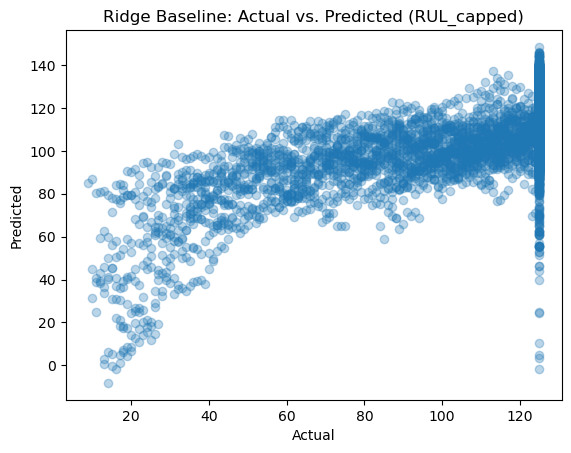

In [58]:
# Plotting actual vs. predicted capped RUL

plt.scatter(y_val, pred_val, alpha=0.3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Ridge Baseline: Actual vs. Predicted ({TARGET})')
plt.show()

[interpretation]

## Per-Engine Evaluation at Final Cycle
a

In [59]:
# Evaluating per-engine at the final cycle

df_val_eval = df_val.copy()
df_val_eval['pred'] = pred_val

last_rows = df_val_eval.loc[df_val_eval.groupby('unit')['cycle'].idxmax()]

rmse_last = np.sqrt(mean_squared_error(last_rows[TARGET], last_rows['pred']))
mae_last = mean_absolute_error(last_rows[TARGET], last_rows['pred'])

print(f'Final-Cycle RMSE: {rmse_last:.3f}')
print(f'Final-Cycle MAE: {mae_last:.3f}')

Final-Cycle RMSE: 25.361
Final-Cycle MAE: 19.902


# XGBoost Regression for RUL
a

# Building DMatrix
a

In [60]:
# Building DMatrix

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

## Defining Hyperparameters
a

In [61]:
# Defining hyperparameters

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

## Training the Model with Early Stopping
a

In [62]:
# Training the model with early stopping

evals = [(dtrain, 'train'), (dval, 'val')]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=100
)

[0]	train-rmse:25.90633	val-rmse:26.49235
[100]	train-rmse:14.71904	val-rmse:17.74192
[200]	train-rmse:13.08642	val-rmse:17.42465
[300]	train-rmse:11.87120	val-rmse:17.27886
[377]	train-rmse:11.08058	val-rmse:17.27440


## Model Evaluation on the Validation Data
a

In [63]:
# Evaluating the model on the validation data

pred_val = xgb_model.predict(dval)

rmse = np.sqrt(mean_squared_error(y_val, pred_val))
mae = mean_absolute_error(y_val, pred_val)
r2 = r2_score(y_val, pred_val)

print(f'XGBoost ({TARGET})')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'R^2: {r2:.3f}')

XGBoost (RUL_capped)
RMSE: 17.274
MAE: 11.431
R^2: 0.593


## Final-Cycle Evaluation
a

In [64]:
# Evaluating at the final-cycle

df_val_eval = df_val.copy()
df_val_eval['pred'] = pred_val

last_rows = df_val_eval.loc[df_val_eval.groupby('unit')['cycle'].idxmax()]

rmse_last = np.sqrt(mean_squared_error(last_rows[TARGET], last_rows['pred']))
mae_last = mean_absolute_error(last_rows[TARGET], last_rows['pred'])

print(f'Final-Cycle RMSE: {rmse_last:.3f}')
print(f'Final-Cycle MAE: {mae_last:.3f}')

Final-Cycle RMSE: 18.166
Final-Cycle MAE: 14.044


[interpretation of differences with ridge]

## Saving the Model
a

In [65]:
# Saving the model

joblib.dump(xgb_model, f'../models/xgboost_{FD}.pkl')

['../models/xgboost_FD004.pkl']